In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import STL10
import matplotlib.pyplot as plt

In [2]:
def train(D, G,
          optd, optg,
          data, epoh=1,
          device='cuda'):
    D.to(device).train(), G.to(device).train()

    for ep in range(1, epoh+1):
        for batch, (img, y) in enumerate(data, 1):
            img_real, n = img.to(device), img.size(0)

            out_real = D(img_real)
            img_fake = G(n)
            out_fake = D(img_fake)
            trg_real = torch.normal(1, 0.02, size=(n, 1), device=device)
            trg_fake = torch.normal(0, 0.02, size=(n, 1), device=device)
            out = torch.cat([out_real, out_fake])
            trg = torch.cat([trg_real, trg_fake])
            dloss = F.binary_cross_entropy(out, trg)
            optd.zero_grad(), dloss.backward(), optd.step()

            img_fake = G(n*2)
            out_fake = D(img_fake)
            trg_fake = torch.normal(1, 0.02, size=(n*2, 1), device=device)
            gloss = F.binary_cross_entropy(out_fake, trg_fake)
            optg.zero_grad(), gloss.backward(), optg.step()

            if batch % 50 == 0:
                print(f'({ep})D: {dloss.item():.4f} G: {gloss.item():.4f} [{batch}/{len(data)}]')

transform = T.Compose([
    T.Resize((64,64)), 
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
data = STL10(
    'drive/MyDrive/data', 'train+unlabeled',
    download=False,
    transform=transform
)
loader = DataLoader(
    data,
    batch_size=100,
    shuffle=True
)

In [58]:
f = lambda x, i: x*2**(i)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
           *[m for i in range(4) for m in
             [nn.Conv2d(f(3, i), f(3, i+1), 4, stride=2, padding=1),
              nn.LeakyReLU(0.2)]
            ],
            nn.Conv2d(48, 1, 4, stride=2, padding=1),
            nn.AvgPool2d(2),
            nn.Sigmoid()
        )
        for p in self.parameters():
            nn.init.normal_(p, 0, 0.02)
 
    def forward(self, x):
        out = self.conv(x).view(-1,1)
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
           *[m for i in range(1,4)[::-1] for m in
             [nn.ConvTranspose2d(f(3, i+1), f(3, i), 4, stride=2, padding=1),
              nn.LeakyReLU(0.2)]
            ],
            nn.ConvTranspose2d(6, 3, 4, stride=2, padding=1),
            nn.Softsign()
        )
        for p in self.parameters():
            nn.init.normal_(p, 0, 0.02)
    
    def forward(self, n=2, seed=None):
        if seed is not None:
            torch.manual_seed(seed)

        device = self.conv[-2].weight.device
        x = torch.randn(n,48,4,4, device=device)
        return self.conv(x)

    def img(self, seed=None):
        self.eval()
        x = (self(1, seed)[0]+1)*127.5
        x = x.detach().cpu().type(torch.uint8)
        return x


D = Discriminator()
optd = Adam(
    D.parameters(),
    lr=1e-4,
    betas=(0.5, 0.999),
    weight_decay=1e-4
)

G = Generator()
optg = Adam(
    G.parameters(),
    lr=1e-3,
    betas=(0.5, 0.999),
    weight_decay=1e-4
)

In [59]:
train(D, G,
      optd, optg,
      loader, 10)
torch.save([D.state_dict(), G.state_dict()], 'gun.pth')

(1)D: 0.6899 G: 0.7032 [50/1050]
(1)D: 0.6158 G: 0.6748 [100/1050]
(1)D: 0.6734 G: 0.8535 [150/1050]
(1)D: 0.7131 G: 0.8631 [200/1050]
(1)D: 0.6931 G: 0.7718 [250/1050]
(1)D: 0.6848 G: 0.7295 [300/1050]
(1)D: 0.6793 G: 0.7136 [350/1050]
(1)D: 0.6680 G: 0.6732 [400/1050]
(1)D: 0.6904 G: 0.6989 [450/1050]
(1)D: 0.6767 G: 0.6868 [500/1050]
(1)D: 0.6532 G: 0.7557 [550/1050]
(1)D: 0.6542 G: 0.7948 [600/1050]
(1)D: 0.6917 G: 0.7736 [650/1050]
(1)D: 0.6884 G: 0.8585 [700/1050]
(1)D: 0.6945 G: 0.8440 [750/1050]
(1)D: 0.6763 G: 0.6610 [800/1050]
(1)D: 0.6920 G: 0.7017 [850/1050]
(1)D: 0.6633 G: 0.7925 [900/1050]
(1)D: 0.6742 G: 0.7143 [950/1050]
(1)D: 0.6833 G: 0.6483 [1000/1050]
(1)D: 0.6775 G: 0.7848 [1050/1050]
(2)D: 0.6766 G: 0.6292 [50/1050]
(2)D: 0.6929 G: 0.7673 [100/1050]
(2)D: 0.6791 G: 0.7834 [150/1050]
(2)D: 0.6871 G: 0.7070 [200/1050]
(2)D: 0.6494 G: 0.6274 [250/1050]
(2)D: 0.6983 G: 0.6317 [300/1050]
(2)D: 0.6669 G: 0.6226 [350/1050]
(2)D: 0.7177 G: 0.7765 [400/1050]
(2)D: 0.6769 G

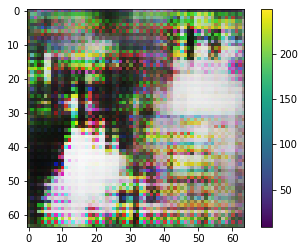

In [68]:
img = G.img().permute(1,2,0)
plt.imshow(img)
plt.colorbar()